In [36]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import contextily as ctx
import shapely
import ee
import geemap
import rasterio
import rioxarray as rxr
from rasterio.mask import mask
from rasterio.crs import CRS
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches
import numpy as np


In [2]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='ee-coberturap')

In [3]:
# --- File paths  ---
root_folder=r"/notebooks/ProyectoFinal/Shapes/"
adi_route = root_folder+'/PNNAmacayacu.shp'
adi_shp = gpd.read_file(adi_route).to_crs(epsg=9377)
adi_shp2 = gpd.read_file(adi_route).to_crs(epsg=4326)
ee_fc = geemap.gdf_to_ee(adi_shp)     # Esto convierte todo el shapefile a una EE FeatureCollection
adi = ee_fc.geometry()

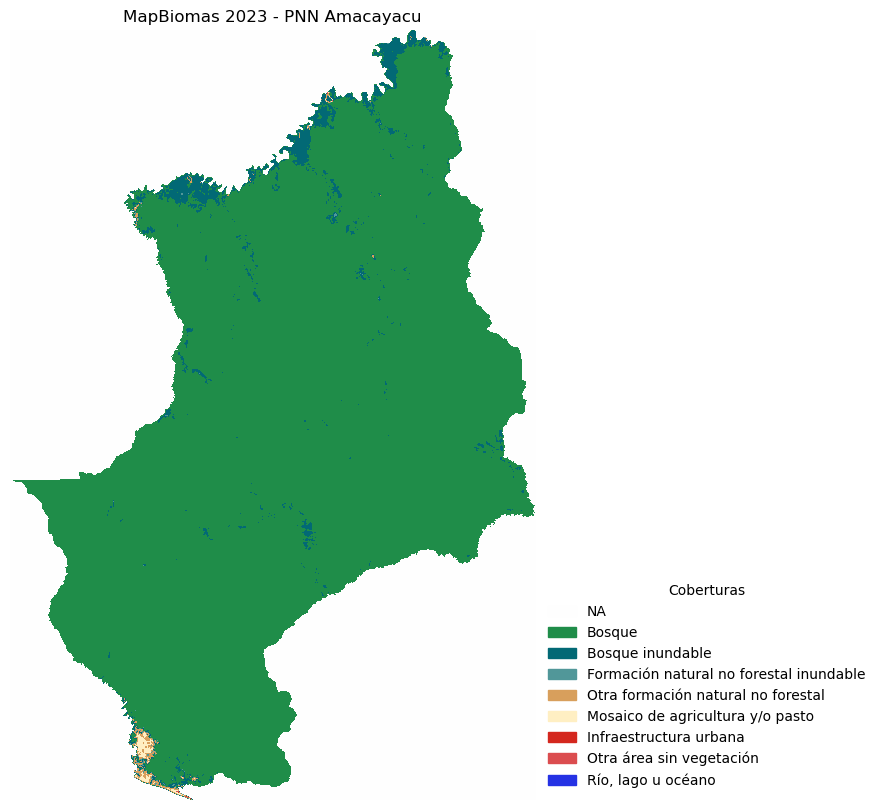

In [44]:
with rasterio.open(root_folder+"/mapbiomas_colombia_collection2_integration_v1-classification_2023.tif") as src:
    out_image, out_transform = mask(src, adi_shp2.geometry, crop=True)
    out_meta = src.meta

# 3. Actualizar los metadatos del raster recortado
out_meta.update({
    "driver": "GTiff",
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform
})


'''
recorte_path = root_folder + "/mapbiomas_amacayacu_2023.tif" 
with rasterio.open(recorte_path, "w", **out_meta) as dest:
    dest.write(out_image) '''

mapbiomas_amacayacu = rxr.open_rasterio(root_folder + "/mapbiomas_amacayacu_2023.tif")
mapbiomas_amacayacu = mapbiomas_amacayacu.rio.write_crs("EPSG:9377")

palette = {
    3:'#1F8D49', ## Bosque
    6:'#026975', ## Bosque inundable
    11:'#519799', ## Formación natural no forestal inundable
    13:'#D89F5C', ## Otra formación natural no forestal
    21:'#FFEFC3', ## Mosaico de agricultura y/o pasto
    24:'#D4271E', ## Infraestructura urbana  
    25:'#DB4D4F', ## Otra área sin vegetación
    33:'#2532E4', ## Río, lago u océano
    0:'#FEFEFE',
}

etiquetas = {
    3: 'Bosque',
    6: 'Bosque inundable',
    11:'Formación natural no forestal inundable',
    13:'Otra formación natural no forestal',
    21:'Mosaico de agricultura y/o pasto', 
    24:'Infraestructura urbana ', 
    25:'Otra área sin vegetación',  
    33:'Río, lago u océano', 
    0:'NA',
}

raster_data = mapbiomas_amacayacu.sel(band=1).values
clases_presentes = np.unique(raster_data[~np.isnan(raster_data)]).astype(int)

# 3. Filtrar las clases que tienen color
clases_filtradas = [c for c in clases_presentes if c in palette]
clases_ordenadas = [c for c in clases_presentes if c in palette]
colores = [palette[c] for c in clases_filtradas]
nombres = [etiquetas[c] for c in clases_filtradas]

# 4. Crear cmap y norm
cmap = ListedColormap(colores)
bounds = [c - 0.5 for c in clases_filtradas] + [clases_filtradas[-1] + 0.5]
norm = BoundaryNorm(bounds, cmap.N)

# 5. Visualizar
# Visualizar mapa sin borde rectangular
plt.figure(figsize=(10, 10))
plt.imshow(raster_data, cmap=cmap, norm=norm)
plt.title("MapBiomas 2023 - PNN Amacayacu")
plt.axis('off')

# Crear leyenda con parches (cuadros de color)
handles = [mpatches.Patch(color=palette[c], label=etiquetas[c]) for c in clases_ordenadas]
plt.legend(
    handles=handles,
    title='Coberturas',
    loc='lower left',
    bbox_to_anchor=(1, 0),  # Mueve la leyenda fuera del mapa
    frameon=False
)

In [14]:
pip install rioxarray

  Using cached rioxarray-0.19.0-py3-none-any.whl.metadata (5.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 17.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: rasterio
    Found existing installation: rasterio 1.3.10
    Uninstalling rasterio-1.3.10:
      Successfully uninstalled rasterio-1.3.10
Note: you may need to restart the kernel to use updated packages.
